<a href="https://colab.research.google.com/github/Shwensc/RooftopSolarAnalysis/blob/main/Solar_panel_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CODE**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

# Set the path to your dataset in Google Drive
source_dir = "/content/drive/MyDrive/Faulty_solar_panel"

# Check if the dataset exists
if os.path.exists(source_dir):
    print("Dataset found. Proceeding...")
else:
    print(f"Error: {source_dir} not found!")


Dataset found. Proceeding...


In [3]:
import os
import shutil
import random

# Define paths
base_dir = "/content/solar_dataset"
folders = ["Bird-drop", "Clean", "Dusty", "Electrical-damage", "Physical-Damage", "Snow-Covered"]

# Create train, val, and test directories
for folder in folders:
    os.makedirs(os.path.join(base_dir, "train", folder), exist_ok=True)
    os.makedirs(os.path.join(base_dir, "val", folder), exist_ok=True)
    os.makedirs(os.path.join(base_dir, "test", folder), exist_ok=True)

# Move files to train, val, and test directories
for folder in folders:
    source_path = os.path.join(source_dir, folder)

    # Ignore non-image files like `desktop.ini`
    images = [f for f in os.listdir(source_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    random.shuffle(images)

    train_split = int(0.7 * len(images))
    val_split = int(0.15 * len(images))

    for i, img in enumerate(images):
        src_img = os.path.join(source_path, img)

        if i < train_split:
            dest_folder = os.path.join(base_dir, "train", folder)
        elif i < train_split + val_split:
            dest_folder = os.path.join(base_dir, "val", folder)
        else:
            dest_folder = os.path.join(base_dir, "test", folder)

        shutil.copy(src_img, os.path.join(dest_folder, img))  # Use copy instead of move to keep original files

print("Dataset organized successfully!")


Dataset organized successfully!


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Image size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation and loading
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Load Pretrained ResNet50
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dense(len(folders), activation="softmax")(x)  # Number of classes

model = Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Save model
model.save("/content/drive/MyDrive/solar_panel_resnet_model.h5")

print("Model training complete! ✅")


Found 607 images belonging to 6 classes.
Found 127 images belonging to 6 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 171s 8s/step - accuracy: 0.1777 - loss: 2.1565 - val_accuracy: 0.2835 - val_loss: 1.7119
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 207s 9s/step - accuracy: 0.2353 - loss: 1.7245 - val_accuracy: 0.3465 - val_loss: 1.6347
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 182s 7s/step - accuracy: 0.3425 - loss: 1.6196 - val_accuracy: 0.2835 - val_loss: 1.6127
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 199s 7s/step - accuracy: 0.3341 - loss: 1.6251 - val_accuracy: 0.3622 - val_loss: 1.5677
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 224s 9s/step - accuracy: 0.3965 - loss: 1.5548 - val_accuracy: 0.3386 - val_loss: 1.5755
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 181s 7s/step - accuracy: 0.3679 - loss: 1.5486 - val_accuracy: 0.3228 - val_loss: 1.5643
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 150s 8s/step - accuracy: 0.3935 - loss: 1.4985 - val_accuracy: 0.3307 - val_loss: 1.5189
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 147s 7s/step - accuracy: 0.4479 - loss: 1.4639 - val_accuracy: 0.2913 - val_loss: 1.

Model training complete! ✅


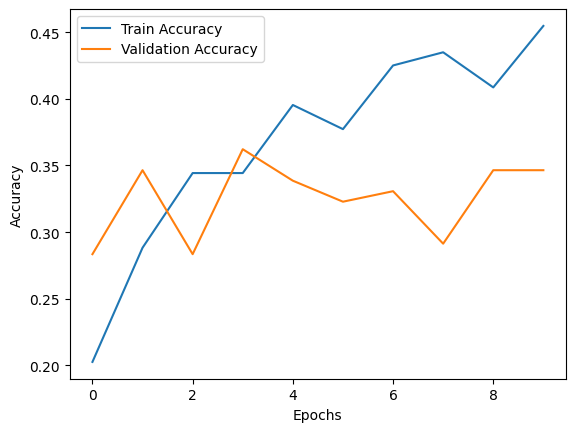

In [5]:
# Plot training history
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [6]:
# Load test dataset
test_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Evaluate model
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2%}")


Found 135 images belonging to 6 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.3689 - loss: 1.4378
Test Accuracy: 40.74%


In [8]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    class_label = list(train_generator.class_indices.keys())[class_index]

    print(f"Predicted class: {class_label}")

# Test with an example image
test_image_path = "/content/drive/MyDrive/Faulty_solar_panel/Dusty/Dust (1).jpg"
predict_image(test_image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: Dusty
